## Identification and classification of damaged/flooded buildings from post-hurricane satellite images

## 4.2 Import relevant libraries

In [70]:
import os
import glob as gb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import montage
from tqdm import tqdm, tqdm_notebook # for progress bar
tqdm.pandas() # instantiate

import cv2

from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.__version__


## 4.3 Load imagedatsets

 Read the file that was prepared in the previous notebooks. We only need certain columns only.

In [108]:
image_df = pd.read_csv('./data/All_images_with_features.csv', usecols=['path','damage','data_split','lat','lon'])

In [109]:
image_df.head()

,path,damage,data_split,lon,lat
0,raw_data/test_another/damage/-96.86103_28.3637...,damage,test_another,-96.861030,28.363781
1,raw_data/test_another/damage/-96.891574_28.364...,damage,test_another,-96.891574,28.364215
2,raw_data/test_another/damage/-96.861869_28.364...,damage,test_another,-96.861869,28.364221
3,raw_data/test_another/damage/-96.8745319999999...,damage,test_another,-96.874532,28.371883
4,raw_data/test_another/damage/-96.874309_28.372...,damage,test_another,-96.874309,28.372196


In [185]:
image_df.shape, image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23000 entries, 0 to 22999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   path        23000 non-null  object 
 1   damage      23000 non-null  object 
 2   data_split  23000 non-null  object 
 3   lon         23000 non-null  float64
 4   lat         23000 non-null  float64
dtypes: float64(2), object(3)
memory usage: 898.6+ KB


((23000, 5), None)

In [197]:
# Separate the data into training, validation, test datasets
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()
image_df_test2 = image_df[image_df['data_split']=='test'].copy()

image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_test2.sort_values('lat', inplace=True)

image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)
image_df_test2.reset_index(drop=True,inplace=True)

In [198]:
print(image_df_train.shape,image_df_val.shape,image_df_test.shape,image_df_test2.shape)

(10000, 5) (2000, 5) (9000, 5) (2000, 5)


In [199]:
image_df_train.head()

,path,damage,data_split,lon,lat
0,raw_data/train_another/damage/-96.860867_28.36...,damage,train_another,-96.860867,28.363774
1,raw_data/train_another/damage/-96.861175_28.36...,damage,train_another,-96.861175,28.363790
2,raw_data/train_another/damage/-96.904856999999...,damage,train_another,-96.904857,28.375248
3,raw_data/train_another/damage/-96.905101_28.37...,damage,train_another,-96.905101,28.375287
4,raw_data/train_another/damage/-96.904766000000...,damage,train_another,-96.904766,28.375337


In [269]:
def GetLabelPath(df):
    
    """
    Function to prepare the path and label of the datasets
    """
    path = df['path'].copy().values
    labels = np.zeros(len(df), dtype=np.int8)
    labels[df['damage'].values=='damage'] = 1
    
    return path, labels

In [270]:
train_path,train_labels = GetLabelPath(image_df_train)
val_path,val_labels = GetLabelPath(image_df_val)
test_path,test_labels = GetLabelPath(image_df_test)
test2_path,test2_labels = GetLabelPath(image_df_test2)

In [271]:
print(test2_path)

['raw_data/test/damage/-96.90534699999999_28.375241.jpeg'
 'raw_data/test/damage/-96.861514_28.41938.jpeg'
 'raw_data/test/damage/-96.888453_28.429508000000002.jpeg' ...
 'raw_data/test/damage/-93.604017_30.793719.jpeg'
 'raw_data/test/damage/-93.560128_30.894917.jpeg'
 'raw_data/test/damage/-93.548123_30.900623.jpeg']


In [272]:
print(test2_labels)

[1 1 1 ... 1 1 1]


In [111]:
# # paths
# train_path = image_df_train['path'].copy().values
# val_path = image_df_val['path'].copy().values
# test_path = image_df_test['path'].copy().values

# # labels
# train_labels = np.zeros(len(image_df_train), dtype=np.int8)
# train_labels[image_df_train['damage'].values=='damage'] = 1

# val_labels = np.zeros(len(image_df_val), dtype=np.int8)
# val_labels[image_df_val['damage'].values=='damage'] = 1

# test_labels = np.zeros(len(image_df_test), dtype=np.int8)
# test_labels[image_df_test['damage'].values=='damage'] = 1

In [273]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))
test2_ds = tf.data.Dataset.from_tensor_slices((test2_path, test2_labels))

## 4.4 Pre-Processing and Image Augmentation

In this section we will do some pre-processing such as : 
- Convert all images to RGB
- Convert the images and the labels to tensor
- Set the shape to 128x128x3 and resize images to 128x128

Following the pre-processing we will do image augmentation (mainly rotation and flipping) to increase the size of the training and validation datasets. Image augmentation is not applied to the test dataset.

### Helper Functions

Prepare some function for image preprocessing, augmentation, etc ...

In [274]:
def cv2_imread(path, label):
    
    """
    This function reads the images and 
    converts the images form BGR to RGB
    """
    img = cv2.imread(path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img, label

def TF_PreProcess(img, label):
    
    """
    Reads the images,converts to tensor, and resize to 128x128
    Reads the labels and convert them to labels
    """
    img = tf.convert_to_tensor(img)
    img = tf.dtypes.cast(img, tf.uint8)
    img.set_shape((128, 128, 3))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [128, 128])
    
    label = tf.convert_to_tensor(label)
    label.set_shape(())
    
    return img, label

# the next 2 function will create augmented images to increase our training and validation dataset

def rotate_augmentation(img, label):
    """
    Augments the images by rotating the original images
    """
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32, seed=1111))
    return img, label

def flip_augmentation(img, label):
    """
    Augments the images by flipping the original images
    """
    img = tf.image.random_flip_left_right(img, seed=2222)
    img = tf.image.random_flip_up_down(img, seed=3333)
    return img, label

In [275]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

# map the cv2 wrapper function using `tf.py_function`
train_ds = train_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)
test2_ds = test2_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)

# map the TensorFlow transformation function
train_ds = train_ds.map(TF_PreProcess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(TF_PreProcess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(TF_PreProcess, num_parallel_calls=AUTOTUNE)
test2_ds = test2_ds.map(TF_PreProcess, num_parallel_calls=AUTOTUNE)

Apply the augmentation functions to the test and validation dataset only. We want to double the size of our datasets that goes into the model training and validation. We will not apply any augmentation to the test datsets, as we want to keep the orignal datsets to as it is.

In [217]:
# Apply image augmentation
augmented_train_ds = train_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_train_ds = augmented_train_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

augmented_val_ds = val_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_val_ds = augmented_val_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.concatenate(augmented_train_ds)
val_ds = val_ds.concatenate(augmented_val_ds)

In [276]:
# double the number of samples in the training and validation splits, due to our augmentation procedure
n_train = len(train_labels)*2
n_val = len(val_labels)*2
n_test = len(test_labels)
n_test2 = len(test2_labels)

# shuffle over the entire dataset, seeding the shuffling for reproducible results
train_ds = train_ds.shuffle(n_train, seed=208, reshuffle_each_iteration=True)
val_ds = val_ds.shuffle(n_val, seed=208, reshuffle_each_iteration=True)
test_ds = test_ds.shuffle(n_test, seed=208, reshuffle_each_iteration=True)
test2_ds = test2_ds.shuffle(n_test2, seed=208, reshuffle_each_iteration=True)

In [116]:
# n_train_check = 0
# for element in train_ds:
#     n_train_check = n_train_check + 1
# print(n_train_check)

# n_val_check = 0
# for element in val_ds:
#     n_val_check = n_val_check + 1
# print(n_val_check)

# n_test_check = 0
# for element in test_ds:
#     n_test_check = n_test_check + 1
# print(n_test_check)

2022-03-31 22:42:01.752549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10848 of 20000
2022-03-31 22:42:10.197408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


20000
4000
9000


In [117]:
# # check that the image was read in correctly
# for image, label in train_ds.take(1):
#     print("image shape : ", image.numpy().shape)
#     print("label       : ", label.numpy())

2022-03-31 22:43:05.217297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16511 of 20000
2022-03-31 22:43:08.587551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


image shape :  (128, 128, 3)
label       :  0


In [231]:
# fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

# i = 0

# for image, label in train_ds.take(10):
#     ax[0,i].imshow(image[:,:,0])
#     ax[0,i].set_title('{} - {}'.format(label.numpy(), 'R'))
#     ax[1,i].imshow(image[:,:,1])
#     ax[1,i].set_title('{} - {}'.format(label.numpy(), 'G'))
#     ax[2,i].imshow(image[:,:,2])
#     ax[2,i].set_title('{} - {}'.format(label.numpy(), 'B'))
#     ax[3,i].imshow(image)
#     ax[3,i].set_title('{} - {}'.format(label.numpy(), 'RGB'))
    
#     i = i+1

## 4.5 Modeling

After doing all the data preparation, it is time to build the model. We will build a Convolutional Neural network (CNN) model using tensorflow. Instead of building the CNN from scratch, we will leverage the learinigns from already trained models, meaning we will do transfer learning. The model we will adopt the learning is the VGG16 model. 

### 4.5.1 Introduction to VGG16

VGG16 is a simple and widely used Convolutional Neural Network (CNN) Architecture used for ImageNet, a large visual database project used in visual object recognition software research. The VGG16 architecture was developed and introduced by Karen Simonyan and Andrew Zisserman from the University of Oxford, in the year 2014. The VGG16 model achieved 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. VGG16 Architecture has 16 layers as can be seen in the image below.

<img src = "./VGG16.png" alt="drawing" width="500"/>


### 4.5.2 Transfer Learning
As mentioned above,we will leverage VGG16 to do transfer learning. Two models will be generated:

- Model 1 
   - take all the convolutional + the max pooling layers of VGG16 and freeze them
   - add a global-average layer and a prediction layer

- Model 2 
    - take all the convolutional + the max pooling layers of VGG16 and freeze the top 15 layers only. The deeper three convolutional layers will be retrained using our input datasets
    - add a global-average layer and a prediction layer

In [277]:
BATCH_SIZE = 32

train_batches_ds = train_ds.batch(BATCH_SIZE)
val_batches_ds = val_ds.batch(BATCH_SIZE)
test_batches_ds = test_ds.batch(BATCH_SIZE)
test2_batches_ds = test2_ds.batch(BATCH_SIZE)

In [120]:
for image_batch, label_batch in train_batches_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-03-31 22:45:31.406257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15853 of 20000
2022-03-31 22:45:35.548103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


(32, 128, 128, 3)
[0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0]


### 4.5.3 Model 1
 Read the VGG16 layers and make sure to set the trainable option to false, so that they will not be re-trained using our dataset.

In [121]:
IMG_SHAPE = (128, 128, 3)
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base layers
pretrained_model.trainable = False

58892288/58889256 [==============================] - 22s 0us/step


In [122]:
feature_batch = pretrained_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [123]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

The VGG16 architecture has 13 convolutional layers and has 14,714,688 parameters. All these parameters are will not be re-trained when generating the first model.

Next, we add the average-global and the prediction layers

In [124]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [125]:
# set the initializers with a seed for reproducible behaviour
prediction_layer = tf.keras.layers.Dense(1,
                                         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1992),
                                         bias_initializer=tf.keras.initializers.GlorotUniform(seed=1992))

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [126]:
model = tf.keras.Sequential([pretrained_model,
                             global_average_layer,
                             prediction_layer])

In [127]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [128]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


The above architecture will be used to generate model 1. It will have a total of 14,715,201 parameters but with only 513 trainable parameters

In [129]:
initial_epochs = 15
steps_per_epoch = n_train//BATCH_SIZE
validation_steps = 20

loss0, accuracy0 = model.evaluate(val_batches_ds, steps=validation_steps)

20/20 [==============================] - 60s 3s/step - loss: 0.8721 - accuracy: 0.4969


In [130]:
history = model.fit(train_batches_ds,
                    epochs=initial_epochs,
                    validation_data=val_batches_ds,
                    validation_steps=validation_steps)

Epoch 1/15


2022-03-31 23:01:54.442822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16628 of 20000
2022-03-31 23:01:57.968297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2139s 3s/step - loss: 0.6565 - accuracy: 0.5355 - val_loss: 0.5942 - val_accuracy: 0.5625
Epoch 2/15


2022-03-31 23:37:32.902126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15403 of 20000
2022-03-31 23:37:37.690849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 6442s 10s/step - loss: 0.5495 - accuracy: 0.6367 - val_loss: 0.5333 - val_accuracy: 0.7109
Epoch 3/15


2022-04-01 01:24:55.445044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5563 of 20000
2022-04-01 01:25:05.446657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10201 of 20000
2022-04-01 01:25:15.445506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12492 of 20000
2022-04-01 01:25:25.464524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14377 of 20000
2022-04-01 01:25:35.457445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17237 of 20000
2022-04-01 01:25:45.446345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19703 of 20000
2022-04-01 01:25:46.663952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shu

625/625 [==============================] - 7627s 12s/step - loss: 0.4907 - accuracy: 0.7627 - val_loss: 0.4741 - val_accuracy: 0.7625
Epoch 4/15


2022-04-01 03:53:27.044395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 560 of 20000
2022-04-01 03:53:27.052681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 561 of 20000
2022-04-01 03:53:27.052713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 562 of 20000
2022-04-01 03:53:27.061789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 563 of 20000
2022-04-01 03:53:27.529216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 564 of 20000
2022-04-01 03:53:27.529360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 565 of 20000
2022-04-01 03:53:27.529580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shu

2022-04-01 03:53:27.765329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 635 of 20000
2022-04-01 03:53:27.765812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 636 of 20000
2022-04-01 03:53:27.766058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 637 of 20000
2022-04-01 03:53:27.771672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 638 of 20000
2022-04-01 03:53:27.772247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 639 of 20000
2022-04-01 03:53:27.773044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 640 of 20000
2022-04-01 03:53:27.773072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shu

625/625 [==============================] - 7845s 10s/step - loss: 0.4497 - accuracy: 0.8049 - val_loss: 0.4338 - val_accuracy: 0.8078
Epoch 5/15


2022-04-01 05:42:48.442564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6118 of 20000
2022-04-01 05:42:58.443085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11778 of 20000
2022-04-01 05:43:08.442741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15227 of 20000
2022-04-01 05:43:18.450448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17194 of 20000
2022-04-01 05:43:28.444310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19284 of 20000
2022-04-01 05:43:31.684364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 4212s 7s/step - loss: 0.4219 - accuracy: 0.8203 - val_loss: 0.4277 - val_accuracy: 0.7906
Epoch 6/15


2022-04-01 06:53:00.425979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15386 of 20000
2022-04-01 06:53:05.141913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2439s 4s/step - loss: 0.4014 - accuracy: 0.8285 - val_loss: 0.4072 - val_accuracy: 0.8109
Epoch 7/15


2022-04-01 07:33:40.045751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7251 of 20000
2022-04-01 07:33:50.045848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11713 of 20000
2022-04-01 07:34:00.045533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15923 of 20000
2022-04-01 07:34:07.300816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3159s 5s/step - loss: 0.3866 - accuracy: 0.8335 - val_loss: 0.3786 - val_accuracy: 0.8453
Epoch 8/15


2022-04-01 08:26:19.540165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8492 of 20000
2022-04-01 08:26:29.542711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13844 of 20000
2022-04-01 08:26:39.540176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18807 of 20000
2022-04-01 08:26:42.109822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3192s 5s/step - loss: 0.3750 - accuracy: 0.8389 - val_loss: 0.3724 - val_accuracy: 0.8297
Epoch 9/15


2022-04-01 09:19:31.406596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8129 of 20000
2022-04-01 09:19:41.410343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13548 of 20000
2022-04-01 09:19:51.406026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18350 of 20000
2022-04-01 09:19:55.121264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3102s 5s/step - loss: 0.3662 - accuracy: 0.8404 - val_loss: 0.3878 - val_accuracy: 0.8250
Epoch 10/15


2022-04-01 10:11:13.614586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8845 of 20000
2022-04-01 10:11:23.614755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13278 of 20000
2022-04-01 10:11:33.614598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18001 of 20000
2022-04-01 10:11:38.059542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3010s 5s/step - loss: 0.3598 - accuracy: 0.8449 - val_loss: 0.3644 - val_accuracy: 0.8500
Epoch 11/15


2022-04-01 11:01:23.365267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8275 of 20000
2022-04-01 11:01:33.362187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14536 of 20000
2022-04-01 11:01:43.362345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18285 of 20000
2022-04-01 11:01:47.426871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3039s 5s/step - loss: 0.3540 - accuracy: 0.8480 - val_loss: 0.3400 - val_accuracy: 0.8625
Epoch 12/15


2022-04-01 11:52:02.531128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8727 of 20000
2022-04-01 11:52:12.535221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15392 of 20000
2022-04-01 11:52:22.533337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19636 of 20000
2022-04-01 11:52:23.510028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3011s 5s/step - loss: 0.3478 - accuracy: 0.8512 - val_loss: 0.3590 - val_accuracy: 0.8203
Epoch 13/15


2022-04-01 12:42:13.436787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9350 of 20000
2022-04-01 12:42:23.442433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14539 of 20000
2022-04-01 12:42:33.436831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18837 of 20000
2022-04-01 12:42:35.701105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3123s 5s/step - loss: 0.3438 - accuracy: 0.8528 - val_loss: 0.3483 - val_accuracy: 0.8422
Epoch 14/15


2022-04-01 13:34:16.467107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8981 of 20000
2022-04-01 13:34:26.465163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14122 of 20000
2022-04-01 13:34:36.463736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18735 of 20000
2022-04-01 13:34:39.246474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3033s 5s/step - loss: 0.3386 - accuracy: 0.8555 - val_loss: 0.3325 - val_accuracy: 0.8406
Epoch 15/15


2022-04-01 14:24:49.344569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9503 of 20000
2022-04-01 14:24:59.349350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15095 of 20000
2022-04-01 14:25:09.248992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2986s 5s/step - loss: 0.3348 - accuracy: 0.8560 - val_loss: 0.3340 - val_accuracy: 0.8484


In [132]:
# Check the model performance on the test dataset

test_loss, test_accuracy = model.evaluate(test_batches_ds)

282/282 [==============================] - 1004s 4s/step - loss: 0.2813 - accuracy: 0.8598


#### Save the model

In [136]:
model.save('./model/VGG16_Base_Model.h5')

In [137]:
# new_model = tf.keras.models.load_model('./model/VGG16_Base_Model.h5')

In [138]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


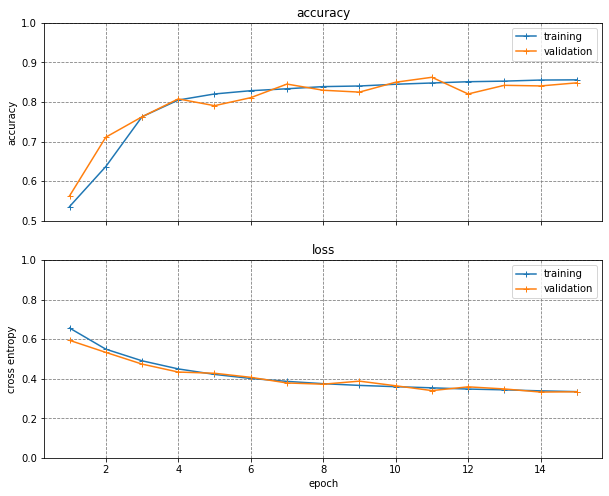

In [131]:
# Plot the accuracy and loss for the training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, initial_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

Model 1 achieved an accuracy of 86% on the training, validation and test datasets. The result shows that the model has generalized very well, no issue of over-fitting. However, the accuracy is way lower than the base model we created based on KNN using color features as well as features generated from RESNET50. We need to biuld a model that can achieve better accuracy than the base model.

Next comes Model 2


### 4.5.4 Model 2 -  Re-train part of the VGG16 layers

In the previous trials we only trained the final dense fully connected layer. Next we try training some layers of the VGG16. We will take all the convolutional + the max pooling layers of VGG16 and freeze the top 15 layers only. The deeper three convolutional layers will be retrained using our input datasets

In [222]:
# unfreeze the layers (we froze the layers when we used them for model 1)
pretrained_model.trainable = True

print("Number of layers in the pre-trained model: ", len(pretrained_model.layers))

# re-train starting from the 15th layer
fine_tune_at = 15
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the pre-trained model:  19


In [143]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/75),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


Model 2 have the same number of paramters as model 1, however model 2 has 7,079,937 trainable parameters as compared to 513 for model 1. In addition, model 2 will be trained using smaller learning rate

In [145]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_batches_ds,
                         validation_steps=validation_steps)

Epoch 16/65


2022-04-01 23:49:51.165172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10997 of 20000
2022-04-01 23:49:59.953831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8770

2022-04-02 00:39:31.829024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3021 of 4000
2022-04-02 00:39:36.308259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3181s 5s/step - loss: 0.2842 - accuracy: 0.8770 - val_loss: 0.2552 - val_accuracy: 0.8844
Epoch 17/65


2022-04-02 00:42:49.703695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3558 of 20000
2022-04-02 00:42:59.705653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6340 of 20000
2022-04-02 00:43:09.787171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8781 of 20000
2022-04-02 00:43:19.714226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11354 of 20000
2022-04-02 00:43:29.705590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13664 of 20000
2022-04-02 00:43:39.703249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15764 of 20000
2022-04-02 00:43:49.702844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9025 

2022-04-02 02:40:12.114124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3197 of 4000
2022-04-02 02:40:15.074651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7215s 11s/step - loss: 0.2284 - accuracy: 0.9025 - val_loss: 0.1930 - val_accuracy: 0.9375
Epoch 18/65


2022-04-02 02:43:04.729648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4229 of 20000
2022-04-02 02:43:14.730260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7847 of 20000
2022-04-02 02:43:24.781364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10610 of 20000
2022-04-02 02:43:34.729909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12721 of 20000
2022-04-02 02:43:44.728522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15234 of 20000
2022-04-02 02:43:54.729096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17639 of 20000
2022-04-02 02:44:03.583405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9155 

2022-04-02 04:39:30.486766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3472 of 4000
2022-04-02 04:39:32.172231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7162s 11s/step - loss: 0.1984 - accuracy: 0.9155 - val_loss: 0.2042 - val_accuracy: 0.9187
Epoch 19/65


2022-04-02 04:42:27.349591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4305 of 20000
2022-04-02 04:42:37.346683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7869 of 20000
2022-04-02 04:42:47.406055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10524 of 20000
2022-04-02 04:42:57.344374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13215 of 20000
2022-04-02 04:43:07.346214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15809 of 20000
2022-04-02 04:43:17.384362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18340 of 20000
2022-04-02 04:43:24.293507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9250 

2022-04-02 06:44:23.515710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3120 of 4000
2022-04-02 06:44:26.733768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7546s 12s/step - loss: 0.1787 - accuracy: 0.9250 - val_loss: 0.2019 - val_accuracy: 0.9156
Epoch 20/65


2022-04-02 06:48:13.357551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3647 of 20000
2022-04-02 06:48:23.356009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6549 of 20000
2022-04-02 06:48:33.356817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9125 of 20000
2022-04-02 06:48:43.359198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11548 of 20000
2022-04-02 06:48:53.355349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13459 of 20000
2022-04-02 06:49:03.356716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15689 of 20000
2022-04-02 06:49:13.370846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9301 

2022-04-02 08:44:30.667512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3562 of 4000
2022-04-02 08:44:31.922341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7160s 11s/step - loss: 0.1643 - accuracy: 0.9301 - val_loss: 0.1465 - val_accuracy: 0.9453
Epoch 21/65


2022-04-02 08:47:34.176474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4135 of 20000
2022-04-02 08:47:44.178965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7841 of 20000
2022-04-02 08:47:54.193817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10975 of 20000
2022-04-02 08:48:04.173030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13770 of 20000
2022-04-02 08:48:14.173268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16318 of 20000
2022-04-02 08:48:24.210432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19017 of 20000
2022-04-02 08:48:27.868689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - 6975s 11s/step - loss: 0.1495 - accuracy: 0.9380 - val_loss: 0.1753 - val_accuracy: 0.9344
Epoch 22/65


2022-04-02 10:43:48.988986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4283 of 20000
2022-04-02 10:43:58.987440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8063 of 20000
2022-04-02 10:44:08.989168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11320 of 20000
2022-04-02 10:44:18.982183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13609 of 20000
2022-04-02 10:44:28.985747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16178 of 20000
2022-04-02 10:44:38.983742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18703 of 20000
2022-04-02 10:44:44.183205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9423 

2022-04-02 12:43:09.123545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3316 of 4000
2022-04-02 12:43:11.469764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7334s 12s/step - loss: 0.1375 - accuracy: 0.9423 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 23/65


2022-04-02 12:46:03.362218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3658 of 20000
2022-04-02 12:46:13.367604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7497 of 20000
2022-04-02 12:46:23.363679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10512 of 20000
2022-04-02 12:46:33.382855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13379 of 20000
2022-04-02 12:46:43.362195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16312 of 20000
2022-04-02 12:46:53.364796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19197 of 20000
2022-04-02 12:46:56.855897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9452 

2022-04-02 14:45:53.103394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3958 of 4000
2022-04-02 14:45:53.229384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7369s 12s/step - loss: 0.1304 - accuracy: 0.9452 - val_loss: 0.1351 - val_accuracy: 0.9547
Epoch 24/65


2022-04-02 14:48:53.066941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4289 of 20000
2022-04-02 14:49:03.067955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7826 of 20000
2022-04-02 14:49:13.193033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11182 of 20000
2022-04-02 14:49:23.090485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19034 of 20000
2022-04-02 14:49:24.470177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9475

2022-04-02 15:40:25.059410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3369 of 4000
2022-04-02 15:40:27.521381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3271s 5s/step - loss: 0.1240 - accuracy: 0.9475 - val_loss: 0.1118 - val_accuracy: 0.9594
Epoch 25/65


2022-04-02 15:43:24.725806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3739 of 20000
2022-04-02 15:43:34.720521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6880 of 20000
2022-04-02 15:43:44.725731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9522 of 20000
2022-04-02 15:43:54.723021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11853 of 20000
2022-04-02 15:44:04.724386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14034 of 20000
2022-04-02 15:44:14.729170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16293 of 20000
2022-04-02 15:44:24.720327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9525 

2022-04-02 17:47:45.078406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3379 of 4000
2022-04-02 17:47:46.906242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7663s 12s/step - loss: 0.1137 - accuracy: 0.9525 - val_loss: 0.1598 - val_accuracy: 0.9375
Epoch 26/65


2022-04-02 17:51:08.185092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3687 of 20000
2022-04-02 17:51:18.187090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7236 of 20000
2022-04-02 17:51:28.530842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10001 of 20000
2022-04-02 17:51:38.196962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12404 of 20000
2022-04-02 17:51:48.184735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14456 of 20000
2022-04-02 17:51:58.184872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16911 of 20000
2022-04-02 17:52:08.187926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Fill

625/625 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9572 

2022-04-02 20:05:49.665589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3254 of 4000
2022-04-02 20:05:52.410930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8270s 13s/step - loss: 0.1059 - accuracy: 0.9572 - val_loss: 0.1638 - val_accuracy: 0.9406
Epoch 27/65


2022-04-02 20:08:58.509129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3322 of 20000
2022-04-02 20:09:08.508399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6851 of 20000
2022-04-02 20:09:18.510356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10106 of 20000
2022-04-02 20:09:28.607368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12790 of 20000
2022-04-02 20:09:38.516928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14636 of 20000
2022-04-02 20:09:48.511579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17026 of 20000
2022-04-02 20:09:58.511889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Fill

625/625 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9601

2022-04-02 21:04:19.126361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3300 of 4000
2022-04-02 21:04:21.152420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3518s 5s/step - loss: 0.0991 - accuracy: 0.9601 - val_loss: 0.1127 - val_accuracy: 0.9531
Epoch 28/65


2022-04-02 21:08:20.832777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3467 of 20000
2022-04-02 21:08:30.834405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6511 of 20000
2022-04-02 21:08:40.832600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9187 of 20000
2022-04-02 21:08:50.841332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11471 of 20000
2022-04-02 21:09:00.836430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13853 of 20000
2022-04-02 21:09:10.841200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16163 of 20000
2022-04-02 21:09:20.853106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - 4359s 7s/step - loss: 0.0934 - accuracy: 0.9640 - val_loss: 0.1617 - val_accuracy: 0.9422
Epoch 29/65


2022-04-02 22:21:00.034850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14272 of 20000
2022-04-02 22:21:07.351673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9646

2022-04-02 23:13:57.646713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3483 of 4000
2022-04-02 23:13:59.235884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3359s 5s/step - loss: 0.0891 - accuracy: 0.9646 - val_loss: 0.1452 - val_accuracy: 0.9484
Epoch 30/65


2022-04-02 23:17:22.293460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3790 of 20000
2022-04-02 23:17:32.301075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6862 of 20000
2022-04-02 23:17:42.295055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9404 of 20000
2022-04-02 23:17:52.301246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11618 of 20000
2022-04-02 23:18:02.292891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13873 of 20000
2022-04-02 23:18:12.303756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15923 of 20000
2022-04-02 23:18:22.301468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - 3336s 5s/step - loss: 0.0847 - accuracy: 0.9676 - val_loss: 0.1093 - val_accuracy: 0.9531
Epoch 31/65


2022-04-03 00:12:58.243874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6419 of 20000
2022-04-03 00:13:08.242232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9473 of 20000
2022-04-03 00:13:18.270128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12257 of 20000
2022-04-03 00:13:28.237991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14755 of 20000
2022-04-03 00:13:38.242430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17062 of 20000
2022-04-03 00:13:48.235217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19104 of 20000
2022-04-03 00:13:52.366154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9685 

2022-04-03 02:23:04.729110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2937 of 4000
2022-04-03 02:23:08.645177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8010s 13s/step - loss: 0.0822 - accuracy: 0.9685 - val_loss: 0.1231 - val_accuracy: 0.9469
Epoch 32/65


2022-04-03 02:26:28.196622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3092 of 20000
2022-04-03 02:26:38.206284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6084 of 20000
2022-04-03 02:26:48.217640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8824 of 20000
2022-04-03 02:26:58.212952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11243 of 20000
2022-04-03 02:27:08.197692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13568 of 20000
2022-04-03 02:27:18.197849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15865 of 20000
2022-04-03 02:27:28.197334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9712 

2022-04-03 04:36:33.861981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3595 of 4000
2022-04-03 04:36:35.361044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7990s 13s/step - loss: 0.0766 - accuracy: 0.9712 - val_loss: 0.0942 - val_accuracy: 0.9625
Epoch 33/65


2022-04-03 04:39:38.372311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3802 of 20000
2022-04-03 04:39:48.368517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6813 of 20000
2022-04-03 04:39:58.364630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9972 of 20000
2022-04-03 04:40:08.378470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12205 of 20000
2022-04-03 04:40:18.370004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14468 of 20000
2022-04-03 04:40:28.365795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17275 of 20000
2022-04-03 04:40:38.373386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9736 

2022-04-03 06:42:09.560592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3009 of 4000
2022-04-03 06:42:12.709690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7550s 12s/step - loss: 0.0703 - accuracy: 0.9736 - val_loss: 0.1365 - val_accuracy: 0.9484
Epoch 34/65


2022-04-03 06:45:28.244968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3916 of 20000
2022-04-03 06:45:38.243622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6735 of 20000
2022-04-03 06:45:48.242236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9503 of 20000
2022-04-03 06:45:58.247484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12167 of 20000
2022-04-03 06:46:08.243081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14270 of 20000
2022-04-03 06:46:18.244538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16684 of 20000
2022-04-03 06:46:28.245113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9742 

2022-04-03 08:48:20.247887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3727 of 4000
2022-04-03 08:48:21.109213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7555s 12s/step - loss: 0.0680 - accuracy: 0.9742 - val_loss: 0.1135 - val_accuracy: 0.9547
Epoch 35/65


2022-04-03 08:51:23.439620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4117 of 20000
2022-04-03 08:51:33.439096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7449 of 20000
2022-04-03 08:51:43.449058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10137 of 20000
2022-04-03 08:51:53.460865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12956 of 20000
2022-04-03 08:52:03.447690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15225 of 20000
2022-04-03 08:52:13.444629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17637 of 20000
2022-04-03 08:52:23.443563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Fill

625/625 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9753 

2022-04-03 10:56:23.606898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3369 of 4000
2022-04-03 10:56:25.869653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7688s 12s/step - loss: 0.0664 - accuracy: 0.9753 - val_loss: 0.1074 - val_accuracy: 0.9625
Epoch 36/65


2022-04-03 10:59:31.293094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3870 of 20000
2022-04-03 10:59:41.288606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6792 of 20000
2022-04-03 10:59:51.287845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9638 of 20000
2022-04-03 11:00:01.288885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12227 of 20000
2022-04-03 11:00:11.289182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14616 of 20000
2022-04-03 11:00:21.291769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16846 of 20000
2022-04-03 11:00:31.290334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - 7537s 12s/step - loss: 0.0603 - accuracy: 0.9785 - val_loss: 0.1045 - val_accuracy: 0.9656
Epoch 37/65


2022-04-03 13:05:08.448113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14818 of 20000
2022-04-03 13:05:15.143831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9779

2022-04-03 14:09:06.760981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3141 of 4000
2022-04-03 14:09:10.500978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 4072s 6s/step - loss: 0.0606 - accuracy: 0.9779 - val_loss: 0.1373 - val_accuracy: 0.9391
Epoch 38/65


2022-04-03 14:13:00.543450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2914 of 20000
2022-04-03 14:13:10.539220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5646 of 20000
2022-04-03 14:13:20.557146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8018 of 20000
2022-04-03 14:13:30.535762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10132 of 20000
2022-04-03 14:13:40.539211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12419 of 20000
2022-04-03 14:13:50.536914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14642 of 20000
2022-04-03 14:14:00.536869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9807 

2022-04-03 16:31:15.338436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3416 of 4000
2022-04-03 16:31:17.700081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8523s 13s/step - loss: 0.0547 - accuracy: 0.9807 - val_loss: 0.0990 - val_accuracy: 0.9656
Epoch 39/65


2022-04-03 16:35:04.003536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3543 of 20000
2022-04-03 16:35:13.994818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6795 of 20000
2022-04-03 16:35:23.995242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9329 of 20000
2022-04-03 16:35:33.998189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11665 of 20000
2022-04-03 16:35:44.001228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13947 of 20000
2022-04-03 16:35:53.996153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15686 of 20000
2022-04-03 16:36:04.011159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9803 

2022-04-03 19:00:56.096726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3538 of 4000
2022-04-03 19:00:58.057156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8953s 14s/step - loss: 0.0534 - accuracy: 0.9803 - val_loss: 0.0955 - val_accuracy: 0.9578
Epoch 40/65


2022-04-03 19:04:17.609055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3714 of 20000
2022-04-03 19:04:27.612171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7396 of 20000
2022-04-03 19:04:37.610636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10391 of 20000
2022-04-03 19:04:47.612012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13242 of 20000
2022-04-03 19:04:57.612005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15544 of 20000
2022-04-03 19:05:07.607129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18107 of 20000
2022-04-03 19:05:15.738847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9798 

2022-04-03 21:10:13.622474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3487 of 4000
2022-04-03 21:10:16.090590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7762s 12s/step - loss: 0.0525 - accuracy: 0.9798 - val_loss: 0.1276 - val_accuracy: 0.9531
Epoch 41/65


2022-04-03 21:13:39.413407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4001 of 20000
2022-04-03 21:13:49.415775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7686 of 20000
2022-04-03 21:13:59.413948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10648 of 20000
2022-04-03 21:14:09.414544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13508 of 20000
2022-04-03 21:14:19.460109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15763 of 20000
2022-04-03 21:14:29.417631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18156 of 20000
2022-04-03 21:14:37.314305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9834

2022-04-03 22:09:42.388578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2905 of 4000
2022-04-03 22:09:47.001408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3587s 6s/step - loss: 0.0486 - accuracy: 0.9834 - val_loss: 0.1046 - val_accuracy: 0.9609
Epoch 42/65


2022-04-03 22:13:27.054584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3462 of 20000
2022-04-03 22:13:37.054958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6267 of 20000
2022-04-03 22:13:47.057041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8889 of 20000
2022-04-03 22:13:57.057164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11069 of 20000
2022-04-03 22:14:07.053288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13258 of 20000
2022-04-03 22:14:17.073643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15124 of 20000
2022-04-03 22:14:27.056278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - 4066s 6s/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.1346 - val_accuracy: 0.9531
Epoch 43/65


2022-04-03 23:21:13.590997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14592 of 20000
2022-04-03 23:21:19.391869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2310s 4s/step - loss: 0.0468 - accuracy: 0.9840 - val_loss: 0.1463 - val_accuracy: 0.9531
Epoch 44/65


2022-04-03 23:59:43.756373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15854 of 20000
2022-04-03 23:59:48.574200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2355s 4s/step - loss: 0.0459 - accuracy: 0.9845 - val_loss: 0.0974 - val_accuracy: 0.9641
Epoch 45/65


2022-04-04 00:38:58.814849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14845 of 20000
2022-04-04 00:39:04.011472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9850 

2022-04-04 02:52:53.915235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2967 of 4000
2022-04-04 02:52:58.135112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8264s 13s/step - loss: 0.0418 - accuracy: 0.9850 - val_loss: 0.1144 - val_accuracy: 0.9578
Epoch 46/65


2022-04-04 02:56:43.791729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3323 of 20000
2022-04-04 02:56:53.803994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 6756 of 20000
2022-04-04 02:57:03.792127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 9537 of 20000
2022-04-04 02:57:13.794823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11489 of 20000
2022-04-04 02:57:23.803114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13488 of 20000
2022-04-04 02:57:33.792089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15497 of 20000
2022-04-04 02:57:43.791731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9871 

2022-04-04 05:14:00.272204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3600 of 4000
2022-04-04 05:14:01.964204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 8447s 13s/step - loss: 0.0371 - accuracy: 0.9871 - val_loss: 0.1091 - val_accuracy: 0.9609
Epoch 47/65


2022-04-04 05:17:31.019033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3862 of 20000
2022-04-04 05:17:41.018718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7698 of 20000
2022-04-04 05:17:51.038753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10690 of 20000
2022-04-04 05:18:01.016328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12966 of 20000
2022-04-04 05:18:11.017345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15322 of 20000
2022-04-04 05:18:21.015135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17866 of 20000
2022-04-04 05:18:28.870691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - 4712s 7s/step - loss: 0.0381 - accuracy: 0.9869 - val_loss: 0.0966 - val_accuracy: 0.9656
Epoch 48/65


2022-04-04 06:36:03.314934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13171 of 20000
2022-04-04 06:36:12.772396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9876 

2022-04-04 08:21:22.886560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3630 of 4000
2022-04-04 08:21:24.442828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 6510s 10s/step - loss: 0.0367 - accuracy: 0.9876 - val_loss: 0.0993 - val_accuracy: 0.9625
Epoch 49/65


2022-04-04 08:24:33.657289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4094 of 20000
2022-04-04 08:24:43.651206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7825 of 20000
2022-04-04 08:24:53.650713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10970 of 20000
2022-04-04 08:25:03.667500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13597 of 20000
2022-04-04 08:25:13.655052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16045 of 20000
2022-04-04 08:25:23.651277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18113 of 20000
2022-04-04 08:25:30.106774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9888 

2022-04-04 10:28:51.994087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3325 of 4000
2022-04-04 10:28:54.305988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7633s 12s/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 0.1119 - val_accuracy: 0.9594
Epoch 50/65


2022-04-04 10:31:47.420722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4227 of 20000
2022-04-04 10:31:57.418401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8287 of 20000
2022-04-04 10:32:07.423081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11220 of 20000
2022-04-04 10:32:17.447300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14200 of 20000
2022-04-04 10:32:27.419889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16768 of 20000
2022-04-04 10:32:37.425611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19304 of 20000
2022-04-04 10:32:39.973370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9886 

2022-04-04 12:26:17.946690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3737 of 4000
2022-04-04 12:26:19.148072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7058s 11s/step - loss: 0.0343 - accuracy: 0.9886 - val_loss: 0.1053 - val_accuracy: 0.9625
Epoch 51/65


2022-04-04 12:29:25.329144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4376 of 20000
2022-04-04 12:29:35.328633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7832 of 20000
2022-04-04 12:29:45.331029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10594 of 20000
2022-04-04 12:29:55.332335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13650 of 20000
2022-04-04 12:30:05.333687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16080 of 20000
2022-04-04 12:30:15.334791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18786 of 20000
2022-04-04 12:30:19.994878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9898 

2022-04-04 14:34:34.076122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3529 of 4000
2022-04-04 14:34:36.717493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7705s 12s/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.1085 - val_accuracy: 0.9641
Epoch 52/65


2022-04-04 14:37:50.751249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4359 of 20000
2022-04-04 14:38:00.757299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8217 of 20000
2022-04-04 14:38:10.756937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12060 of 20000
2022-04-04 14:38:20.751466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14814 of 20000
2022-04-04 14:38:30.762031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17129 of 20000
2022-04-04 14:38:40.750003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19880 of 20000
2022-04-04 14:38:41.138679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9896 

2022-04-04 16:43:33.274855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3536 of 4000
2022-04-04 16:43:35.121591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7739s 12s/step - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.1229 - val_accuracy: 0.9563
Epoch 53/65


2022-04-04 16:46:50.239503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4124 of 20000
2022-04-04 16:47:00.234723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8081 of 20000
2022-04-04 16:47:10.251325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10734 of 20000
2022-04-04 16:47:20.240297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13169 of 20000
2022-04-04 16:47:30.239132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15929 of 20000
2022-04-04 16:47:40.233359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18467 of 20000
2022-04-04 16:47:46.658137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9910 

2022-04-04 18:56:41.213740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3938 of 4000
2022-04-04 18:56:41.353654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7982s 13s/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0982 - val_accuracy: 0.9656
Epoch 54/65


2022-04-04 18:59:52.946588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3863 of 20000
2022-04-04 19:00:02.949524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7565 of 20000
2022-04-04 19:00:12.939416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10940 of 20000
2022-04-04 19:00:22.962472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13236 of 20000
2022-04-04 19:00:32.941233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15809 of 20000
2022-04-04 19:00:42.942109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18163 of 20000
2022-04-04 19:00:49.689658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - 4211s 7s/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.1261 - val_accuracy: 0.9516
Epoch 55/65


2022-04-04 20:10:04.365617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13819 of 20000
2022-04-04 20:10:09.139078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 6925s 11s/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.1188 - val_accuracy: 0.9641
Epoch 56/65


2022-04-04 22:05:29.870159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11886 of 20000
2022-04-04 22:05:39.868572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18613 of 20000
2022-04-04 22:05:42.271917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2657s 4s/step - loss: 0.0254 - accuracy: 0.9924 - val_loss: 0.0870 - val_accuracy: 0.9719
Epoch 57/65


2022-04-04 22:49:52.028670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14318 of 20000
2022-04-04 22:49:57.193491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2456s 4s/step - loss: 0.0253 - accuracy: 0.9932 - val_loss: 0.1306 - val_accuracy: 0.9594
Epoch 58/65


2022-04-04 23:30:47.904751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11716 of 20000
2022-04-04 23:30:56.615938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 2457s 4s/step - loss: 0.0232 - accuracy: 0.9934 - val_loss: 0.1207 - val_accuracy: 0.9594
Epoch 59/65


2022-04-05 00:12:10.125331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7916 of 20000
2022-04-05 00:12:20.117434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14982 of 20000
2022-04-05 00:12:30.117434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 19588 of 20000
2022-04-05 00:12:30.998347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9919 

2022-04-05 02:13:57.308371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3589 of 4000
2022-04-05 02:13:59.482422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7484s 12s/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.1000 - val_accuracy: 0.9688
Epoch 60/65


2022-04-05 02:16:54.644128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4187 of 20000
2022-04-05 02:17:04.645910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7996 of 20000
2022-04-05 02:17:14.649531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10529 of 20000
2022-04-05 02:17:24.663611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12830 of 20000
2022-04-05 02:17:34.645138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15264 of 20000
2022-04-05 02:17:44.643687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17573 of 20000
2022-04-05 02:17:54.645614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Fill

625/625 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9930 

2022-04-05 04:12:50.830482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3768 of 4000
2022-04-05 04:12:51.502914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7126s 11s/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.1040 - val_accuracy: 0.9703
Epoch 61/65


2022-04-05 04:15:40.519456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4153 of 20000
2022-04-05 04:15:50.528222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7896 of 20000
2022-04-05 04:16:00.524581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11274 of 20000
2022-04-05 04:16:10.518801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13713 of 20000
2022-04-05 04:16:20.519298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16096 of 20000
2022-04-05 04:16:30.520988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18676 of 20000
2022-04-05 04:16:35.895264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - 7089s 11s/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 0.1219 - val_accuracy: 0.9625
Epoch 62/65


2022-04-05 06:13:49.973726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14218 of 20000
2022-04-05 06:13:56.860152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9948

2022-04-05 07:06:16.878285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3160 of 4000
2022-04-05 07:06:20.279508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 3353s 5s/step - loss: 0.0201 - accuracy: 0.9948 - val_loss: 0.1109 - val_accuracy: 0.9734
Epoch 63/65


2022-04-05 07:09:43.468606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3076 of 20000
2022-04-05 07:09:53.465123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 5959 of 20000
2022-04-05 07:10:03.473679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8843 of 20000
2022-04-05 07:10:13.465646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11165 of 20000
2022-04-05 07:10:23.466240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13550 of 20000
2022-04-05 07:10:33.474295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15968 of 20000
2022-04-05 07:10:43.467429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filli

625/625 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9944 

2022-04-05 09:10:49.599489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3453 of 4000
2022-04-05 09:10:51.410388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7456s 12s/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 0.1051 - val_accuracy: 0.9609
Epoch 64/65


2022-04-05 09:13:59.774154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3948 of 20000
2022-04-05 09:14:09.774772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7029 of 20000
2022-04-05 09:14:20.006849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10001 of 20000
2022-04-05 09:14:29.774951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12501 of 20000
2022-04-05 09:14:39.772475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15183 of 20000
2022-04-05 09:14:49.769725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18867 of 20000
2022-04-05 09:14:51.043885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuf

625/625 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9948 

2022-04-05 11:12:27.917458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3210 of 4000
2022-04-05 11:12:30.312772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7295s 12s/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.1353 - val_accuracy: 0.9656
Epoch 65/65


2022-04-05 11:15:35.075343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3779 of 20000
2022-04-05 11:15:45.073028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 7312 of 20000
2022-04-05 11:15:55.087941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10270 of 20000
2022-04-05 11:16:05.074663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12659 of 20000
2022-04-05 11:16:15.079434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15225 of 20000
2022-04-05 11:16:25.074264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 17404 of 20000
2022-04-05 11:16:35.073026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Fill

625/625 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9948 

2022-04-05 13:24:18.750957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3619 of 4000
2022-04-05 13:24:19.705690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


625/625 [==============================] - 7904s 13s/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0849 - val_accuracy: 0.9688


In [146]:
model.save('./model/VGG16_Model_retrained.h5')

#### Visualize accuracy and loss

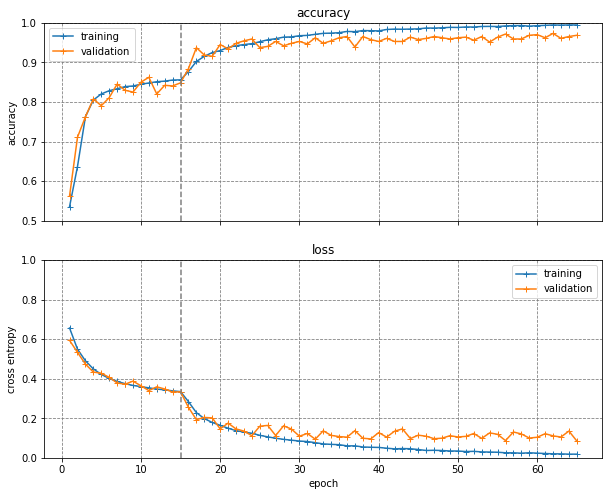

In [147]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, total_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')
ax[0].axvline(initial_epochs, c='C7', ls='--')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].axvline(initial_epochs, c='C7', ls='--')

plt.show()

In [149]:
# Validate the model performance on the test and validation datasets not used on training
val_loss, val_accuracy = model.evaluate(val_batches_ds)

125/125 [==============================] - 369s 3s/step - loss: 0.1118 - accuracy: 0.9622


In [150]:
test_loss, test_accuracy = model.evaluate(test_batches_ds)

282/282 [==============================] - 860s 3s/step - loss: 0.1270 - accuracy: 0.9524


In [181]:
def GetLabelPred(df):
    eval_labels = np.array([])
    eval_predictions = np.array([])
    first = True
    for images, labels in df.take(-1): 
        if first:
            eval_images = images.numpy()
            first = False
        else:
            eval_images = np.concatenate((eval_images, images.numpy()), axis=0)
        eval_labels = np.append(eval_labels, labels.numpy())
        eval_predictions = np.append(eval_predictions, model.predict_on_batch(images))

    # convert predictions from logit to binary
    eval_predictions[eval_predictions>=0] = 1
    eval_predictions[eval_predictions<0] = 0

    # change dtype to int
    eval_predictions = eval_predictions.astype(int)
    eval_labels = eval_labels.astype(int)
    
    return eval_labels, eval_predictions

In [292]:
test_labels, test_predictions = GetLabelPred(test_batches_ds)

In [227]:
eval_labels, eval_predictions = GetLabelPred(val_batches_ds)

In [278]:
test2_labels, test2_predictions = GetLabelPred(test2_batches_ds)

In [290]:
test_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [304]:
import itertools
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_split = ['eval','test']

def show_model_results(in_model):
    """
    Function to plot the prediction results of a certain model. 
    It plots and prints ROC curve, confusion matrix, accuracy and classification report
    
    """
    fig, m_axs = plt.subplots(2, 2, figsize=(12, 12))
    m_axs = m_axs.flatten()
    all_rows = []
    classfication_report_df = pd.DataFrame()
    ax1 = m_axs[0]
#     ax1 = m_axs

    k = 1
    for i in np.arange(1,4):#data_split:
        
        if i == 1:
            predictions = test2_predictions
            labels = test2_labels
            title= 'test'
        elif i == 2:  
            predictions = test_predictions
            labels = test_labels 
            title= 'test_another'
        else:
            predictions = eval_predictions
            labels = eval_labels
            title= 'validation_another'
            
        fpr, tpr, _ = roc_curve(labels, predictions)
        auc = roc_auc_score(labels, predictions)
        acc = accuracy_score(labels, predictions>0.5)

        cnf_matrix = confusion_matrix(labels, predictions)
        class_report = classification_report(labels, predictions, output_dict=True)
        class_report_df = pd.DataFrame(class_report).transpose()
    #         class_report_df['split'] = c_split
        classfication_report_df = pd.concat([classfication_report_df,class_report_df],axis=0)

        # Plot ROC curve
        ax1.plot(fpr, tpr, '.-', label=  '{}, AUC {:0.2f}, Accuracy: {:2.0%}'.format(title, auc, acc))
        all_rows += [pd.DataFrame({'class': eval_labels, 'prediction': np.clip(eval_predictions, 0, 1), 
                                   'type': 'damage'})]

        ax1.legend(loc='lower right')
        ax1.set_xlabel('False Positive Rate (FPR)')
        ax1.set_ylabel('True Positive Rate (TPR)') 

        #  plot_confusion_matrix(cnf_matrix, classes=class_names)
        ax = m_axs[k]
        class_names = ['True','False']
        im = ax.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title('Confusion Matrix: {}'.format(title))

        tick_marks = np.arange(len(class_names))
        ax.set_xticks(tick_marks, class_names, rotation=45)
        ax.set_yticks(tick_marks, class_names)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')  

        # for colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        # Just to write the values in the confusion matrix
        fmt = 'd'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            ax.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")


        plt.tight_layout()

        k = k + 1

    c_all_df = pd.concat(all_rows)

    return classfication_report_df,c_all_df

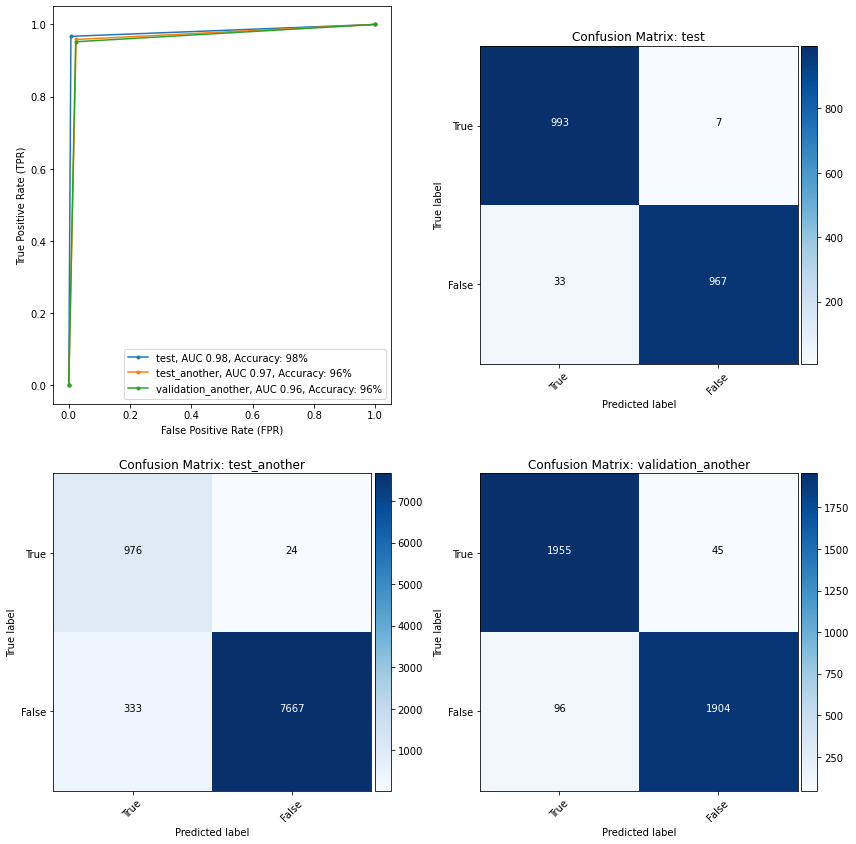

In [305]:
classfication_report_df, result_df = show_model_results(model)

In [306]:
classfication_report_df

,precision,recall,f1-score,support
0,0.967836,0.993000,0.980257,1000.000000
1,0.992813,0.967000,0.979737,1000.000000
accuracy,0.980000,0.980000,0.980000,0.980000
macro avg,0.980325,0.980000,0.979997,2000.000000
weighted avg,0.980325,0.980000,0.979997,2000.000000
0,0.745607,0.976000,0.845388,1000.000000
1,0.996879,0.958375,0.977248,8000.000000
accuracy,0.960333,0.960333,0.960333,0.960333
macro avg,0.871243,0.967187,0.911318,9000.000000
weighted avg,0.968960,0.960333,0.962597,9000.000000


Model 2 results are much better compared to model 1 and the base line model. Model 2 has achieved an accuracy of 96% for the unbalanced test dataset. Accuracy of 86% and 93% were achieved by model 1 and the baseline model using resnet50 respectively.

## 4.6 Summary

We used VGG16 model to build our finest and best model. We built two models out of it. One (Model 1) that fixes all the convolutional layers and another (Model 2) that re-trains the last three convolutional layers. The best results were achieved by model 2  and hence will be used as our final model.

Model 2 has out-performed the baseline model significantly, especially when the dataset was unbalanced. The table below summarized the results of the baseline and final model.


Eventhough our model's performance is very good, let's investigate some of the mis-classified images

In [308]:
first = True
for images, labels in test_batches_ds.take(-1): 
    if first:
        test_images = images.numpy()
        first = False
    else:
        test_images = np.concatenate((test_images, images.numpy()), axis=0)


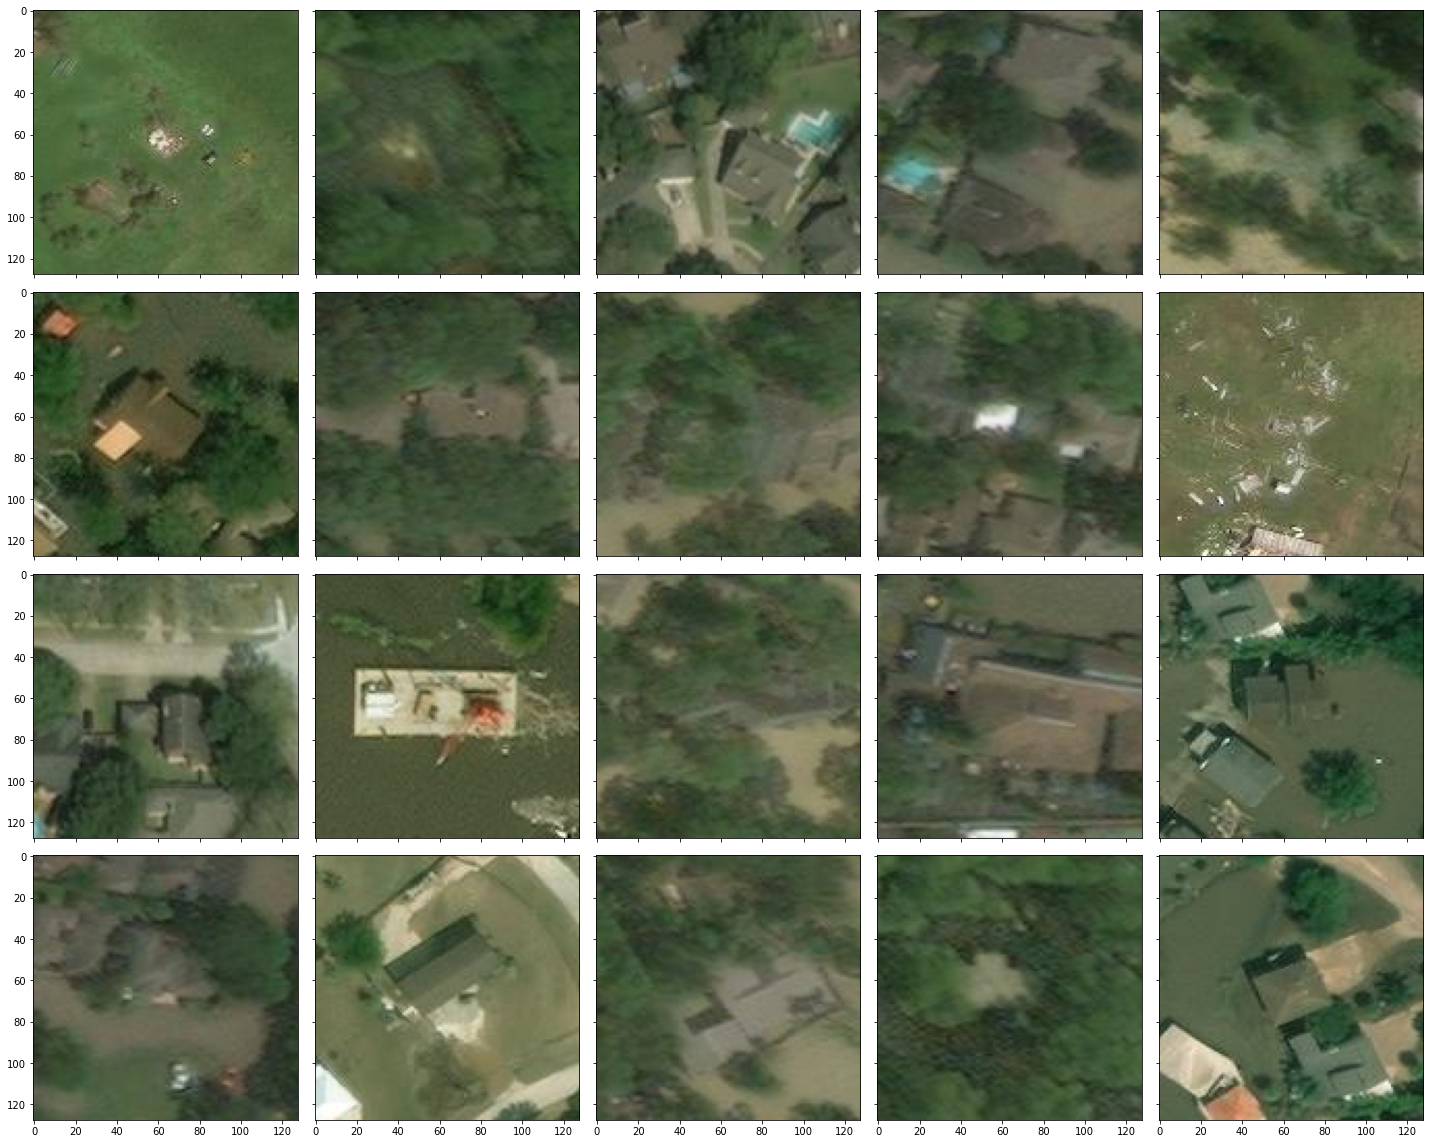

In [320]:
FP_images = test_images[(test_labels==0)&(test_predictions==1)]
FN_images = test_images[(test_labels==1)&(test_predictions==0)]

FP = np.arange(10, dtype=int)*2
FN = np.arange(10, dtype=int)*2

fig, ax = plt.subplots(4,5, sharex=True, sharey=True, figsize=(20,16))

ax = ax.flatten()

for i in range(10):
    ax[i].imshow(FP_images[FP[i]])
    
for i in range(10):
    ax[i+10].imshow(FN_images[FN[i]])
    
fig.tight_layout()
plt.show()

- The first two rows show images that has been falsely classified as damaged. Looking at the images visually, some of them do look somewhat flooded, or the images does not look clear. The same observation can also be said for the images that are mis-classified as not-damged, when in reality they are damaged.

Finally, we compare our best results to the study done by Quoc Dung Cao and Youngjun Choe on this dataset. According to the paper published by the afore mentioned authors , the best results were obtained by a model built from scratch as CNN + data augmentation + 50% dropout using Adam optimizer. Their model has achieved an accuracy of 98%, 97.29% and 97.03% for the validation, test data(balanced) and another test(unbalanced data). In coparison our model 2 has achieved an accuracy of 96%, 98% and 96% for the validation, test data(balanced) and another test(unbalanced data).

From this comparison we can see that by doing transfer learning you can achieve similar performance to the ones biult from scratch. This could save a lot of time and compute expenses. However, this could be due to the reason that our problem is binary classification only. For problems that have many classes, a more sophosticated CNN may be needed.